In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN



# Utils

In [ ]:
def categorize_quantile(ser: pd.Series, n_category):
    assert(n_category == 3 or n_category == 5)
    for i in range(1, n_category):
        print(i / n_category, ser.quantile(i / n_category))

In [49]:
def missing_report(data):
	nan_values = pd.DataFrame()
	nan_values['missing_count'] = data.isna().sum()
	nan_values['missing_percentage'] = nan_values['missing_count'] / data.shape[0]
	nan_values = nan_values[nan_values['missing_count'] > 0]
	return nan_values.round(4)

In [50]:
def fill_missing_with_knn(df, columns):
    imputer = KNNImputer(n_neighbors=5)
    df[columns] = imputer.fit_transform(df[[columns]])
    
    return df

In [51]:
def fill_missing_by_distribution(column):
    value_counts = column.dropna().value_counts()
    probabilities = value_counts / value_counts.sum()
    column = column.fillna(column.apply(lambda x: np.random.choice(value_counts.index, p=probabilities) if pd.isna(x) else x))
    
    return column

In [52]:
data = pd.read_csv('diabetic_data.csv')

encounter_id = data['encounter_id']

# Preprocess

## duplicated

In [53]:
data.duplicated().sum()

0

## Null

### Question Mark as Null Value

through the dataset, there are some missing datas:
- ? marks
- in `admission_type_id`, `discharge_disposition_id` and `admission_source_id` there are `NULL`, `Unknown/Invalid`, `Not Mapped` and `Not Available`.

In [54]:
data = data.replace('?', np.nan)

In [55]:
data['admission_type_id'] = data['admission_type_id'].replace([5, 6, 8], np.nan)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace([18, 25, 26], np.nan)
data['admission_source_id'] = data['admission_source_id'].replace([9, 15, 17, 20, 21], np.nan)

In [56]:
missing_report(data)

,missing_count,missing_percentage
race,2273,0.0223
weight,98569,0.9686
admission_type_id,10396,0.1022
discharge_disposition_id,4680,0.0460
admission_source_id,7067,0.0694
payer_code,40256,0.3956
medical_specialty,49949,0.4908
diag_1,21,0.0002
diag_2,358,0.0035
diag_3,1423,0.0140


We drop values wit high null ratio.

In [57]:
data = data.drop(
    columns=[
        'weight',
        'payer_code',
        'max_glu_serum', 
        'A1Cresult',
        'medical_specialty'
    ], axis=1)

In [58]:
missing_report(data)

,missing_count,missing_percentage
race,2273,0.0223
admission_type_id,10396,0.1022
discharge_disposition_id,4680,0.0460
admission_source_id,7067,0.0694
diag_1,21,0.0002
diag_2,358,0.0035
diag_3,1423,0.0140


## Useless data

There is two type of useless data:

1. unique onevalue for each sample such as IDs.

2. datas with only one value

In [59]:
for col in data.columns:
    print(col, data[col].nunique())

encounter_id 101766
patient_nbr 71518
race 5
gender 3
age 10
admission_type_id 5
discharge_disposition_id 24
admission_source_id 14
time_in_hospital 14
num_lab_procedures 118
num_procedures 7
num_medications 75
number_outpatient 39
number_emergency 33
number_inpatient 21
diag_1 716
diag_2 748
diag_3 789
number_diagnoses 16
metformin 4
repaglinide 4
nateglinide 4
chlorpropamide 4
glimepiride 4
acetohexamide 2
glipizide 4
glyburide 4
tolbutamide 2
pioglitazone 4
rosiglitazone 4
acarbose 4
miglitol 4
troglitazone 2
tolazamide 3
examide 1
citoglipton 1
insulin 4
glyburide-metformin 4
glipizide-metformin 2
glimepiride-pioglitazone 2
metformin-rosiglitazone 2
metformin-pioglitazone 2
change 2
diabetesMed 2
readmitted 3


In [60]:
data = data.drop(columns=['encounter_id', 'patient_nbr', 'examide', 'citoglipton'], axis=1)

## Feature Speccific Processing

### race

In [61]:
data['race'].value_counts(dropna=False)

race
Caucasian          76099
AfricanAmerican    19210
NaN                 2273
Hispanic            2037
Other               1506
Asian                641
Name: count, dtype: int64

In [62]:
data['race'] = data['race'].replace(np.nan, 'Other')

In [63]:
data['race'].value_counts(dropna=False)

race
Caucasian          76099
AfricanAmerican    19210
Other               3779
Hispanic            2037
Asian                641
Name: count, dtype: int64

### gender

In [64]:
data['gender'].value_counts(dropna=False)

gender
Female             54708
Male               47055
Unknown/Invalid        3
Name: count, dtype: int64

In [65]:
data['gender'] = data['gender'].replace('Unknown/Invalid', np.nan)

In [66]:
data['gender'] = fill_missing_by_distribution(data['gender'])

In [67]:
data['gender'].value_counts(dropna=False)

gender
Female    54711
Male      47055
Name: count, dtype: int64

### age

In [68]:
data['age'].value_counts(dropna=False)

age
[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: count, dtype: int64

In [69]:
data['age'] = data['age'].replace({
    '[0-10)': 0,
    '[10-20)': 1,
    '[20-30)': 2,
    '[30-40)': 3,
    '[40-50)': 4,
    '[50-60)': 5,
    '[60-70)': 6,
    '[70-80)': 7,
    '[80-90)': 8,
    '[90-100)': 9
})

C:\Users\asus\AppData\Local\Temp\ipykernel_23300\3108464427.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['age'] = data['age'].replace({


In [70]:
data['age'].value_counts(dropna=False)

age
7    26068
6    22483
5    17256
8    17197
4     9685
3     3775
9     2793
2     1657
1      691
0      161
Name: count, dtype: int64

### admission_type_id

In [71]:
data['admission_type_id'].value_counts(dropna=False)

admission_type_id
1.0    53990
3.0    18869
2.0    18480
NaN    10396
7.0       21
4.0       10
Name: count, dtype: int64

In [72]:
data['admission_type_id'] = fill_missing_by_distribution(data['admission_type_id'])
data['admission_type_id'].value_counts(dropna=False)

admission_type_id
1.0    60152
3.0    21089
2.0    20490
7.0       24
4.0       11
Name: count, dtype: int64

### discharge_disposition_id 

we group the similar ones to reduce complexity.

In [73]:
# dischare to home
data['discharge_disposition_id'].replace(
    to_replace=[
        1, 6
	],
    value = 'TO HOME',
    inplace = True
)

data['discharge_disposition_id'].replace(
    to_replace=[
		2, 3, 4, 5, 10, 22, 23, 24, 27, 28, 29, 30, 15, 16, 17,	
	],
    value = 'TO HEALTHCARE',
    inplace = True
)

data['discharge_disposition_id'].replace(
    to_replace=[
		11, 19, 20, 21
	],
    value = 'EXPIRED',
    inplace = True
)

data['discharge_disposition_id'].replace(
    to_replace=[
		7, 8, 9, 12, 13, 14
	],
    value = 'OTHER',
    inplace = True
)

C:\Users\asus\AppData\Local\Temp\ipykernel_23300\2025307947.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['discharge_disposition_id'].replace(


In [74]:
data['discharge_disposition_id'] = data['discharge_disposition_id'].astype('string')

In [75]:
data['discharge_disposition_id'] = fill_missing_by_distribution(data['discharge_disposition_id'])

In [76]:
data['discharge_disposition_id'].value_counts(dropna=False)

discharge_disposition_id
TO HOME          76687
TO HEALTHCARE    21730
EXPIRED           1744
OTHER             1605
Name: count, dtype: Int64

### admission_source_id 

Here we also group the similar ones.

In [77]:
data['admission_source_id'].replace(
    to_replace=[1, 2, 3],
    value = 'referrals',
    inplace = True
)

data['admission_source_id'].replace(
    to_replace=[4, 5, 6, 10, 22, 25, 26],
    value = 'transfer',
    inplace = True
)

data['admission_source_id'].replace(
    to_replace=[11, 12, 13, 14, 23, 24],
    value = 'delivery',
    inplace = True
)

data['admission_source_id'].replace(
    to_replace=[7, 8],
    value = 'emergency',
    inplace = True
)

data['admission_source_id'].replace(
    to_replace=[9, 18, 19, np.nan],
    value = 'other',
    inplace = True
)

C:\Users\asus\AppData\Local\Temp\ipykernel_23300\514725720.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['admission_source_id'].replace(


In [78]:
data['admission_source_id'].value_counts(dropna = False)

admission_source_id
emergency    57510
referrals    30856
other         7067
transfer      6328
delivery         5
Name: count, dtype: int64

In [79]:
data['admission_source_id'] = data['admission_source_id'].replace('delivery', 'other')
data['admission_source_id'].value_counts(dropna = False)


admission_source_id
emergency    57510
referrals    30856
other         7072
transfer      6328
Name: count, dtype: int64

### time_in_hospital

we categorize this feature according to the quantiles, also there are more numeric data like this, but their information are more critical and useful, so we keep the original values.

In [81]:
categorize_quantile(data['time_in_hospital'], 3)

0.3333333333333333 3.0
0.6666666666666666 5.0


In [82]:
def to_group_time_in_hospital(x):
	if x <= 3:
		return 'short'
	elif 3 < x <= 5:
		return 'moderate'
	else:
		return 'long'


data['time_in_hospital'] = data['time_in_hospital'].apply(to_group_time_in_hospital)
data['time_in_hospital'].value_counts(dropna = False)

time_in_hospital
short       49188
long        28688
moderate    23890
Name: count, dtype: int64

### diag_i

According to [WikiPedia ICD-9 codes](<\https://en.wikipedia.org/wiki/List_of_ICD-9_codes_240%E2%80%93279:_endocrine,_nutritional_and_metabolic_diseases,_and_immunity_disorders>), we categorize the codes. 

In [83]:
data['diag_1'] = fill_missing_by_distribution(data['diag_1'])
data['diag_2'] = fill_missing_by_distribution(data['diag_2'])
data['diag_3'] = fill_missing_by_distribution(data['diag_3'])


In [84]:
def categorize_diag(block: str):
	block = str(block)
	if(block.startswith('V')):
		return 'Supplementary Classification of Factors influencing Health Status and Contact with Health Services'
	if(block.startswith('E')):
		return 'Supplementary Classification of External Causes of Injury and Poisoning'
	if(block.startswith('M')):
		return 'Morphology of Neoplasms'
	
	block = float(block)
	if 1 <= block < 140:
		return "Infectious and Parasitic Diseases"
	elif 140 <= block < 240:
		return "Neoplasms"
	elif 240 <= block < 280:
		return "Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders"
	elif 280 <= block < 290:
		return "Diseases of the Blood and Blood-forming Organs"
	elif 290 <= block < 320:
		return "Mental Disorders"
	elif 320 <= block < 390:
		return "Diseases of the Nervous System and Sense Organs"
	elif 390 <= block < 460:
		return "Diseases of the Circulatory System"
	elif 460 <= block < 520:
		return "Diseases of the Respiratory System"
	elif 520 <= block < 580:
		return "Diseases of the Digestive System"
	elif 580 <= block < 630:
		return "Diseases of the Genitourinary System"
	elif 630 <= block < 680:
		return "Complications of Pregnancy, Childbirth, and the Puerperium"
	elif 680 <= block < 710:
		return "Diseases of the Skin and Subcutaneous Tissue"
	elif 710 <= block < 740:
		return "Diseases of the Musculoskeletal System and Connective Tissue"
	elif 740 <= block < 760:
		return "Congenital Anomalies"
	elif 760 <= block < 780:
		return "Certain Conditions originating in the Perinatal Period"
	elif 780 <= block < 800:
		return "Symptoms, Signs and Ill-defined Conditions"
	elif 800 <= block < 1000:
		return "Injury and Poisoning"
	else:
		return "Unknown Title"
	


In [85]:
data['diag_1'] = data['diag_1'].apply(categorize_diag)
data['diag_2'] = data['diag_2'].apply(categorize_diag)
data['diag_3'] = data['diag_3'].apply(categorize_diag)

## Drugs


Drugs has 4 categories, to keep the similarity, we encode them manually.(so the labels respond to the same things.)

In [86]:
drugs = [
	'metformin',
	'repaglinide',
	'nateglinide',
	'chlorpropamide',
	'glimepiride',
	'acetohexamide',
	'glipizide',
	'glyburide',
	'tolbutamide',
	'pioglitazone',
	'rosiglitazone',
	'acarbose',
	'miglitol',
	'troglitazone',
	'tolazamide',
	'insulin',
	'glyburide-metformin',
	'glipizide-metformin',
	'glimepiride-pioglitazone',
	'metformin-rosiglitazone',
	'metformin-pioglitazone',
]


In [87]:
def categorize_drug(usage):
    if(usage == 'No'):
        return 0
    if(usage == 'Steady'):
        return 1
    if(usage == 'Up'):
        return 2
    if(usage == 'Down'):
        return 3

for drug in drugs:
    data[drug] = data[drug].apply(categorize_drug)

## Label Encoding

we need numeric values to continue.

In [88]:
encoder = LabelEncoder()

In [89]:
for col in data.columns:
	if data[col].dtype == 'object' or data[col].dtype == 'string':
		data[col] = encoder.fit_transform(data[col])

In [90]:
data

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2,0,0,1.0,2,2,2,41,0,1,...,0,0,0,0,0,0,0,1,0,2
1,2,0,1,1.0,3,0,2,59,0,18,...,0,2,0,0,0,0,0,0,1,1
2,0,0,2,1.0,3,0,2,11,5,13,...,0,0,0,0,0,0,0,1,1,2
3,2,1,3,1.0,3,0,2,44,1,16,...,0,2,0,0,0,0,0,0,1,2
4,2,1,4,1.0,3,0,2,51,0,8,...,0,1,0,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,0,1,7,1.0,2,0,2,51,0,16,...,0,3,0,0,0,0,0,0,1,1
101762,0,0,8,1.0,2,3,1,33,3,18,...,0,1,0,0,0,0,0,1,1,2
101763,2,1,7,1.0,3,0,2,53,0,9,...,0,3,0,0,0,0,0,0,1,2
101764,2,0,8,2.0,2,0,0,45,2,21,...,0,2,0,0,0,0,0,0,1,2


# Dimensionality Reduction

## PCA

Principal Component Analysis (PCA) is a powerful technique used for dimensionality reduction, exploratory data analysis, and visualization. Let me break it down for you:

1. Objective:
- PCA aims to transform a set of correlated variables into a new coordinate system where the directions (principal components) capture the largest variation in the data.
- These principal components are linear combinations of the original variables.

2. How It Works:
- Given a dataset with multiple dimensions (variables), PCA identifies the directions along which the data varies the most.
- The first principal component (PC1) is the linear combination of the original variables that explains the most variance.
- Subsequent principal components (PC2, PC3, etc.) explain the remaining variance after removing the effect of the previous components.
- Each principal component is orthogonal (uncorrelated) to the others.

3. Mathematical Details:
- Let’s say we have a dataset with (n) data points and (m) features (variables).
- The covariance matrix of the features is computed.
- The eigenvectors and eigenvalues of this covariance matrix are calculated.
- The eigenvectors represent the directions of the principal components, and the eigenvalues indicate the amount of variance explained by each component.

4. Applications:
- Data Visualization: PCA is often used to reduce high-dimensional data to 2D or 3D for visualization.
- Feature Selection: By keeping only the top principal components, we can reduce the number of features while retaining most of the information.

- Noise Reduction: Removing less significant components can help filter out noise.

- Clustering and Classification: PCA can improve the performance of machine learning models.

### Outliers Visualization

This is a visualization of data with two features to only show the outliers to ease the comprehension of both PCA and outliers.

<Axes: >

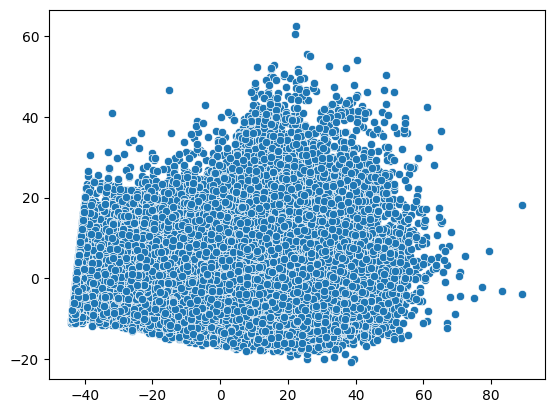

In [91]:
pca = PCA(n_components=2) 
xpca_outlier = pca.fit_transform(data)
sea.scatterplot(x=xpca_outlier[:, 0], y=xpca_outlier[:, 1])

### Reduction according to portion of Variance

In [124]:
pca = PCA(n_components=0.95, svd_solver='full') 
xpca = pca.fit_transform(data)

In [125]:
xpca.shape

(101766, 5)

### Handling Outliers

In [126]:
mean_values = np.mean(xpca, axis=0)
std_values = np.std(xpca, axis=0)
z_scores = (xpca - mean_values) / std_values


threshold = 3
outliers = np.abs(z_scores) > threshold


In [127]:
mask = np.full(shape=xpca.shape[0], fill_value=False, dtype=bool)
for i in range(xpca.shape[1]):
    mask += outliers[:, i]

In [128]:
xpca = xpca[~mask, :]

In [129]:
xpca.shape

(100334, 5)

# Unsupervised Learning 

In [130]:
clusters = pd.DataFrame(columns=['encounter_id', 'kmean_label', 'dbscan_label'])
clusters['encounter_id'] = encounter_id

## K-Means

In [116]:
results = pd.DataFrame(columns=['n_clusters', 'silhouette_score'])

for n_clusters in range(2, 11):
	kmeans = KMeans(n_clusters=n_clusters)
	kmeans.fit(xpca)
	labels = kmeans.labels_
	score = silhouette_score(xpca, labels)
	results.loc[len(results)] = {'n_clusters': n_clusters, 'silhouette_score': score}

In [117]:
results

,n_clusters,silhouette_score
0,2,0.388750
1,3,0.334554
2,4,0.257924
3,5,0.220455
4,6,0.228445
5,7,0.199047
6,8,0.175376
7,9,0.189954
8,10,0.183992


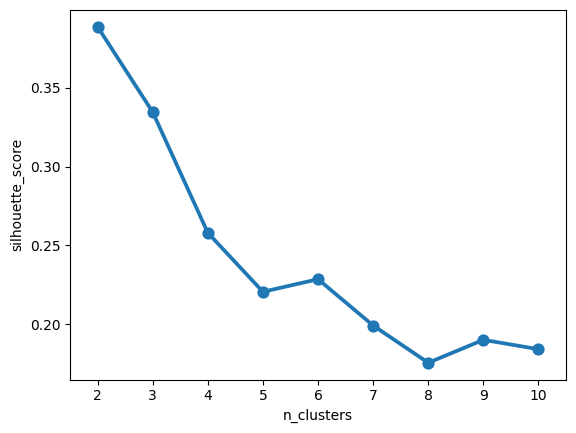

In [119]:
sea.pointplot(x = results['n_clusters'], y=results['silhouette_score'])
plt.show()

In [131]:
predicted = np.full(shape=data.shape[0], fill_value=-1)

kmeans = KMeans(n_clusters=2)
kmeans.fit(xpca)
labels = kmeans.labels_
predicted[~mask] = labels

clusters['kmean_label'] = predicted

## DBSCAN

### Scaling

We need to scale the data for DBSCAN, because it uses a distance metric so we need to scale the values to have a better distances.

We chose the min-max scaling because the is no need to normalize the values, just we need to keep them in the same aspects.

In [139]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

We need to re-make the reduced vectors:

In [140]:
pca = PCA(n_components=0.90, svd_solver='full') 

xpca = pca.fit_transform(data_scaled)
xpca.shape

(101766, 13)

As you noticed, it is harder to keep the variance of scaled values, so it uses more features. we do not handle the outlires due to DBSCAN can detect outliers itself.

In [147]:
results_db = pd.DataFrame(columns=['eps', 'min_samples', 'silhouette_score'])

epsilons = [0.4, 0.8]
min_samples = [50, 100, 150]
for eps in epsilons:
	for min_sample in min_samples:
		db = DBSCAN(eps = eps, min_samples = min_sample).fit(xpca)
		labels = db.labels_
		score = silhouette_score(xpca, labels)
		results_db.loc[len(results_db)] = {'eps': eps, 'min_samples': min_sample, 'silhouette_score': score}


In [148]:
results_db

,eps,min_samples,silhouette_score
0,0.4,50,-0.216420
1,0.4,100,-0.316341
2,0.4,150,-0.304524
3,0.8,50,0.208266
4,0.8,100,0.208248
5,0.8,150,0.208421


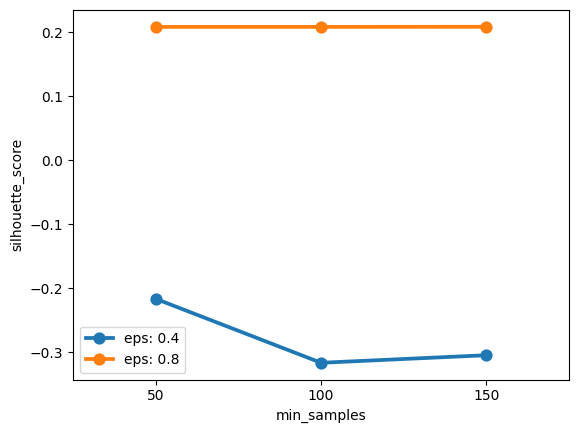

In [150]:
for eps in epsilons:
	sea.pointplot(
		x=results_db[results_db['eps'] == eps]['min_samples'], 
		y=results_db[results_db['eps'] == eps]['silhouette_score'],
		label=f'eps: {eps}' 
	)
plt.legend()
plt.show()

In [153]:
db = DBSCAN(eps = 0.8, min_samples = 150).fit(xpca)
labels = db.labels_

clusters['dbscan_label'] = labels

## Save Clusters

In [154]:
clusters.to_csv('./clusters.csv')

# Questions



**1. What preprocessing steps did you perform on the dataset? Provide clear reasons for each decision made.**

- `Duplicates`: droped them.

- `NULL`: if there were many null values in a feature, we dropped them but if there was a few of them, we impute with two methods, KNN(k-nearest neighbours) and distribution-driven method which impute according to distribution of values.

- `Feature Specific Processing`: it is explained through the report.

**2. What portion of the dataset did you retain during dimensionality reduction, and which variables were retained? Could you elaborate on the rationale behind this decision?**

there was about 40 features which reduced to 5.

**3. Include a plot illustrating the silhouette coefficient plotted against the input parameters for each clustering method within the report file.**

in the report.

**4. How can we determine the optimal number of clusters in K-Means?**

`Elbow Method`:

- The Elbow Method helps find the “elbow point” in a plot of the within-cluster sum of squares (WCSS) against the number of clusters (k).
- WCSS measures the total distance between data points and their cluster centroids.
As the number of clusters increases, WCSS tends to decrease. However, beyond a certain point, the reduction becomes marginal.
- The “elbow point” represents the optimal k where adding more clusters doesn’t significantly reduce WCSS.


`Silhouette Score`:

- The Silhouette Score assesses how well each data point fits into its assigned cluster.
- It ranges from -1 to 1:
	- A high positive value indicates that the point is well-clustered.
	- A value near 0 suggests overlapping clusters.
	- A negative value means the point might be assigned to the wrong cluster.
- Calculate the Silhouette Score for different values of k and choose the one with the highest score.

**5. How can we determine the optimal epsilon value and minPts in DBSCAN?**


`Epsilon (ε)`:
- Epsilon defines the radius around each data point within which we search for neighboring points.
- Too small ε may result in many noise points (outliers) being considered as clusters.
- Too large ε may merge distinct clusters into a single cluster.
- Methods to find ε:
	- Knee Method: Plot the k-distance graph (distance to the kth nearest neighbor) and look for the “knee” point where the curve changes significantly.
	- Visual Inspection: Visualize the data and choose ε based on the density of points.
	- Domain Knowledge: Consider the problem domain and choose ε accordingly.

`MinPts`:
- MinPts specifies the minimum number of points required to form a dense region (core point).
- Core points have at least MinPts neighbors within ε.
- Methods to find MinPts:
	- Domain Knowledge: Understand the data and choose MinPts based on the expected density of clusters.
	- Heuristic: A common heuristic is to set MinPts as the dimensionality of the data plus 1 (MinPts = d + 1, where d is the number of features).
	- Silhouette Score: Experiment with different MinPts values and choose the one that maximizes the Silhouette Score.


**6. When would you recommend using K-Means, and when would you suggest using DBSCAN instead?**

`K-Means`:
- Use Case:
	+ K-Means is appropriate when you have a clear expectation of the number of clusters (k) in your data.
	+ It assumes that clusters are spherical, equally sized, and have similar densities.
- Advantages:
	+ Simple and easy to implement.
	+ Works well when clusters are well-separated.
	+ Efficient for large datasets.
- Limitations:
	+ Sensitive to initial centroids (random initialization).
	+ Struggles with non-spherical or overlapping clusters.
	+ Requires scaling features to have equal influence.


`DBSCAN`:
- Use Case:
	- The number of clusters is unknown or varies.
	+ Clusters have varying shapes and densities.
	+ Noise (outliers) detection is essential.
	+ It forms clusters based on density rather than assuming a fixed number of clusters.
- Advantages:
	+ Automatically detects the number of clusters.
	+ Robust to noise and outliers.
	+ Handles irregularly shaped clusters.
- Limitations:
	+ Sensitive to the choice of parameters (ε and MinPts).
	+ May struggle with clusters of varying densities.
	+ Not suitable for high-dimensional data.